In [11]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

import json

from PIL import Image

import torch

import torchvision
from torchvision import transforms

from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

import timm

import omegaconf

クラスインデックス

In [12]:
class_index = json.load(open('../config/class_index.json', 'r'))
print(class_index)
len(class_index)

{'0': 'NORMAL', '1': 'PNEUMONIA'}


2

In [13]:
model = timm.create_model('convnext_base', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('../models/convnext_base.pth', map_location=torch.device('cpu')))
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate=none)
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), e

In [14]:
# 画像の読み込み
img = Image.open('../input/PNEUMONIA/person1946_bacteria_4874.jpeg').convert('RGB')

In [15]:
transform = {
    'input': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    'original': transforms.Compose([
        transforms.Resize((224, 224)),
        ]),
}

In [16]:
input_img = transform['input'](img).unsqueeze(0)

In [17]:
# Grad-CAM
guided_gc = GuidedGradCam(model, model.stages[3].blocks[2].drop_path)
attribution = guided_gc.attribute(
    input_img,
    target=1
)
attribution_img = attribution[0].cpu().permute(1,2,0).detach().numpy()

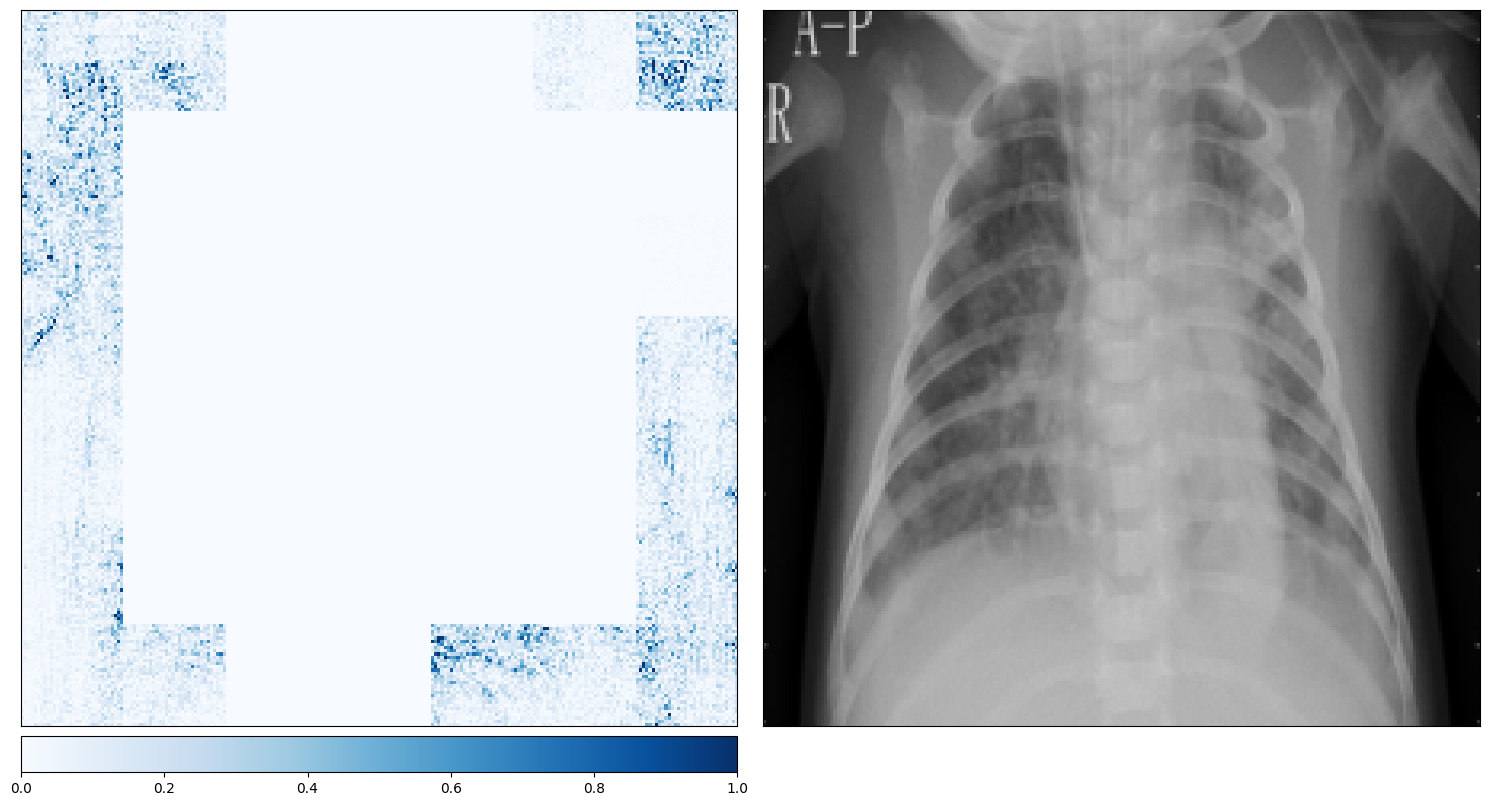

In [18]:
_ = viz.visualize_image_attr_multiple(attribution_img,
                                        np.array(transform['original'](img)),
                                        methods=["heat_map", "original_image"],
                                        signs = ["absolute_value", "all"],
                                        fig_size=(15, 15),
                                        show_colorbar = True
                                        )